# Declarations

## Imports

In [1]:
import re
import os
import math
import string
import random
import requests
import importlib
import itertools

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import numpy as np
import pandas as pd

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import plotly.graph_objects as go

from tqdm import tqdm

from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

tfk = tf.keras
tfkl = tf.keras.layers
kb = tf.keras.backend

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.13.0
Num GPUs Available:  1


## Constants

In [4]:
# Randomness
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [5]:
# Filepaths
kaggle = False

model_versions = ["v4.0"]

github_repo = "raul-singh/Rise-of-Transformers-Project"
github_branch = "main"
github_python_prefix = ["Code", "Notebooks", "py_files"]
github_clip_models_prefix = ["Code", "Models"] if kaggle else ["..", "Models"]
github_pyfiles_data = [
    {"name": "preprocessing", "imports": ["import_datasets", "load_image_from_path"]},
    {"name": "evaluation", "imports": [
        "EvalMetrics as evm", "compute_total_relevance", "generate_image_embeddings", "generate_text_embeddings", 
        "index_to_reference", "compute_relevant_at_k", "decode_concepts"
    ]}, 
    {"name": "clip", "imports": ["build_clip"]}
]
github_pyfiles = ["/".join(github_python_prefix) + "/" + pf["name"] + ".py" for pf in github_pyfiles_data]
github_clip_models = [f"{'/'.join(github_clip_models_prefix)}/{version}.yaml" for version in model_versions]

kaggle_dataset1 = "/kaggle/input/transformers-hackathon/"
kaggle_dataset2 = "/kaggle/input/transformers-hackathon-features/"
kaggle_weights = "/kaggle/input/clip-weights/"
kaggle_relevance = "/kaggle/input/clip-relevance/"

image_dir = "./resized_train"
relevance_dir = "./relevance"
caption_pred_file = "caption_prediction_train.csv"
concept_det_file = "concept_detection_train.csv"
concept_file = "concepts.csv"
classification_file = "classification.csv"
clip_weights_files = [f"{version}.h5" for version in model_versions] if kaggle else [None for _ in model_versions]

if kaggle:
    image_dir = kaggle_dataset1 + image_dir
    relevance_dir = kaggle_relevance + relevance_dir
    caption_pred_file = kaggle_dataset2 + caption_pred_file
    concept_det_file = kaggle_dataset2 + concept_det_file
    concept_file = kaggle_dataset2 + concept_file
    classification_file = kaggle_dataset2 + classification_file
    clip_weights_files = [kaggle_weights + weight for weight in clip_weights_files]

In [6]:
# Train/Val/Test split and filter percentages
test_size = 0.2
val_size = 0
filter_percent_dataset = 1

# Batch size
batch_size = 32

# Import dataset types and shapes
in_feat_typ = {'caption': tf.string, 'concepts': tf.bool, 'image path': tf.string}
feature_shapes = {'image': (128, 128, 3), 'caption': (), 'concepts': (8374)}

# Output dataset structure
x_features_eval = ['image path', 'image']
y_features_eval = ['caption', 'concepts']

# Define parameters for dataset import
dataset_parameters = [{
    'x_features': x_features_eval, 'y_features': y_features_eval,
    'x_dict': True, 'y_dict': True,           
    'shuffle_buffer_size': 1,
    'batch_size': batch_size,
    'cached': True,
}]

# Classification labels
classification_labels = ['angiography', 'echocardiography', 'ultrasound', 'tomography', 'xray']

## Meta-Imports

In [7]:
def clean_recursive_imports(source, import_list, prefix):
    import_prefix = re.sub(r"/", ".", prefix)
    for target_import in import_list:
        source = re.sub(r"from[ \t]+" + re.escape(target_import) + r"[ \t]+import", f"from {import_prefix + target_import} import", source)
    return source
    
def import_py_from_repo(repository, branch, filepath, prefix, recursive_imports_list=None):
    # Build path for retrieval and write name
    path_pre = "https://raw.githubusercontent.com/"
    path = path_pre + repository + "/" + branch + "/" + filepath 
    write_path = prefix + filepath.split("/")[-1]
    print("Downloading file from " + path)
    # Obtain raw text from file
    text = requests.get(path).text
    # Clean recursive imports
    text = clean_recursive_imports(text, recursive_imports_list, prefix) if recursive_imports_list else text
    # Create subdirectories if not exist
    os.makedirs(os.path.dirname(write_path), exist_ok=True)
    # Write file
    f = open(write_path, "w")
    f.write(text)
    f.close()

In [8]:
if kaggle:
    for pf_data, py_file in zip(github_pyfiles_data, github_pyfiles):
        import_py_from_repo(
            github_repo, github_branch, py_file, 
            "/".join(github_python_prefix) + "/", 
            recursive_imports_list=[pf["name"] for pf in github_pyfiles_data],
        )
        import_string = f'from {".".join(github_python_prefix) + "." + pf_data["name"]} import {", ".join(pf_data["imports"])}'
        exec(import_string)
    
    for model in github_clip_models:
        import_py_from_repo(github_repo, github_branch, model, "/".join(github_clip_models_prefix) + "/")
        
else:
    for pf_data in github_pyfiles_data:
        import_string = f'from py_files.{pf_data["name"]} import {", ".join(pf_data["imports"])}'
        exec(import_string)

# Preprocessing

In [9]:
# Import custom classification dataset
df = pd.read_csv(classification_file)
dataset = tf.data.Dataset.from_tensor_slices(dict(df))
dataset = dataset.map(lambda x: {'image': load_image_from_path(image_dir + "/" + x['image path']), 'label': x['label']})
dataset = dataset.batch(batch_size)

# Model Import

In [11]:
models = []
for structure, weights in zip(github_clip_models, clip_weights_files):
    print(f"Creating model {structure}")
    clip_image_encoder, clip_text_encoder, clip = build_clip(structure, weights_path=weights)
    models.append({
        "image_encoder": clip_image_encoder,
        "clip_text_encoder": clip_text_encoder,
        "clip": clip,
    })

Creating model Code/Models/v4.0.yaml
82420632/82420632 [==============================] - 3s 0us/step
Models downloaded.
Building clip...
Loading parameters...
Done.


In [12]:
# Select the loaded model to evaluate
clip_image_encoder, clip_text_encoder, clip = models[0].values()

del models

# Model Evaluation

## Evaluation Definitions

In [13]:
def zeroshot_classifier(image_embeddings, class_embeddings, normalize=True):
    if normalize:
        image_embeddings = tf.math.l2_normalize(image_embeddings, axis=1)
        class_embeddings = tf.math.l2_normalize(class_embeddings, axis=1)
    similarities = tf.matmul(image_embeddings, class_embeddings, transpose_b=True)
    return tf.nn.softmax(similarities, axis=1)

In [14]:
def zero_shot_complete(images, classes):
    reference, image_embeddings = generate_image_embeddings(
        clip_image_encoder,
        images,
        dataset_pred_map=lambda x: x['image'],
        dataset_ref_map=lambda x: x['label'],
    )
    _, text_embeddings = generate_text_embeddings(
        clip_text_encoder,
        classes,
        is_list=True
    )

    reference = [e.numpy().decode('UTF8') for e in reference]
    return zeroshot_classifier(image_embeddings, text_embeddings), reference

In [15]:
def evaluate_zeroshot(reference, results, classification_labels, images=None, vis=False):
    print("\n### Scoring zero-shot classification data ###")
    print(f'Classes:\t{classification_labels}')
    
    if images:
        images = images.unbatch()
    else:
        images = np.full_like(reference, None)

    y_pred = []
    for image, element_ref, result in zip(images, reference, results):

        idx = np.argmax(result)
        confidence = np.max(result)
        
        label = classification_labels[idx]
        y_pred.append(label)
        
        if vis and image:
            plt.figure()
            plt.imshow(np.array(image["image"].numpy(), dtype=np.float64))
            plt.show()

            print(f'Prediction:\tThis is a photo of a {label}, confidence {confidence*100:.3f}%')
            print(f'Actual class:\t{element_ref}')

            if label == element_ref:
                print(f'Right Prediction')
            else:
                print(f'Wrong Prediction')

            print(f'#########################################################')

    print(classification_report(reference, y_pred, target_names=classification_labels, labels=classification_labels, zero_division=0))
    ConfusionMatrixDisplay.from_predictions(reference, y_pred, xticks_rotation="vertical", )

## Dataset Metrics

In [16]:
# Generating embeddings for image-to-text and text-to-image tasks
reference, image_embeddings = generate_image_embeddings(
    clip_image_encoder,
    dataset,
    dataset_pred_map=lambda x: x['image'],
    dataset_ref_map=lambda x: x['label'],
)

_, text_embeddings = generate_text_embeddings(
    clip_text_encoder,
    classification_labels,
    is_list=True
)

reference = [e.numpy().decode('UTF8') for e in reference]

Generating image embeddings
129/129 [==============================] - 14s 79ms/step
Generating text embeddings
1/1 [==============================] - 0s 464ms/step


## Zero-Shot Classification Task


### Scoring zero-shot classification data ###
Classes:	['angiography', 'echocardiography', 'ultrasound', 'tomography', 'xray']
                  precision    recall  f1-score   support

     angiography       0.70      0.82      0.76       299
echocardiography       0.80      0.94      0.86       211
      ultrasound       0.95      0.89      0.92       520
      tomography       0.96      0.95      0.96      1873
            xray       0.98      0.96      0.97      1208

        accuracy                           0.94      4111
       macro avg       0.88      0.91      0.89      4111
    weighted avg       0.94      0.94      0.94      4111



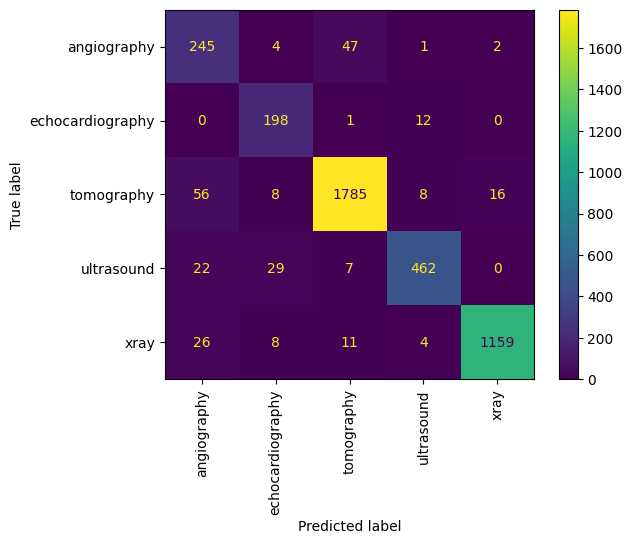

In [17]:
zeroshot_results = zeroshot_classifier(image_embeddings, text_embeddings)
evaluate_zeroshot(reference, zeroshot_results, classification_labels, vis=False)

## Playground

In [18]:
images = dataset.unbatch().skip(21).take(5).batch(batch_size)

zeroshot_results_p, reference_p = zero_shot_complete(images, classification_labels)

Generating image embeddings
1/1 [==============================] - 1s 1s/step
Generating text embeddings
1/1 [==============================] - 0s 17ms/step



### Scoring zero-shot classification data ###
Classes:	['angiography', 'echocardiography', 'ultrasound', 'tomography', 'xray']


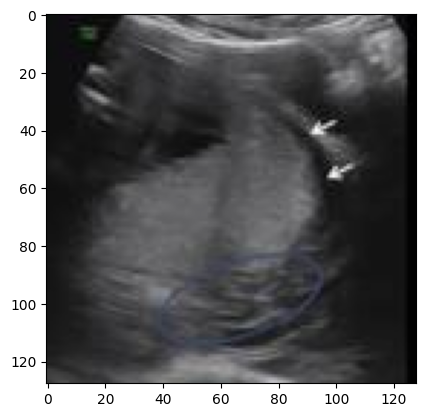

Prediction:	This is a photo of a ultrasound, confidence 27.977%
Actual class:	ultrasound
Right Prediction
#########################################################


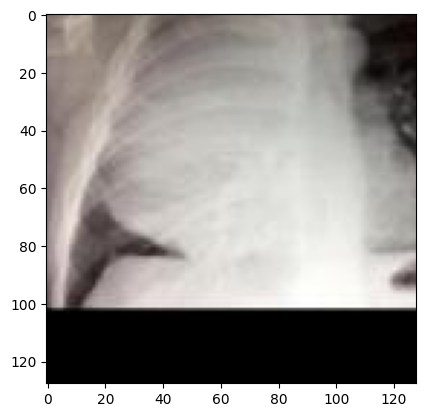

Prediction:	This is a photo of a xray, confidence 29.654%
Actual class:	xray
Right Prediction
#########################################################


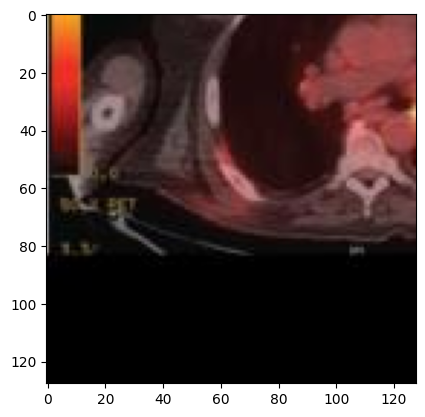

Prediction:	This is a photo of a tomography, confidence 23.439%
Actual class:	tomography
Right Prediction
#########################################################


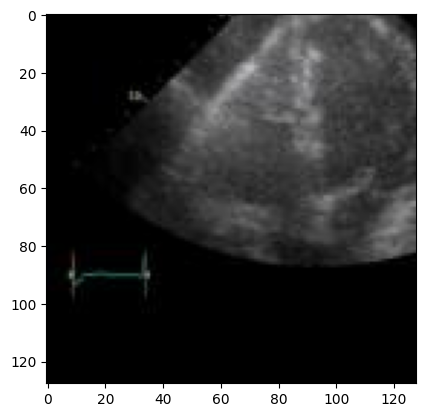

Prediction:	This is a photo of a echocardiography, confidence 27.998%
Actual class:	echocardiography
Right Prediction
#########################################################


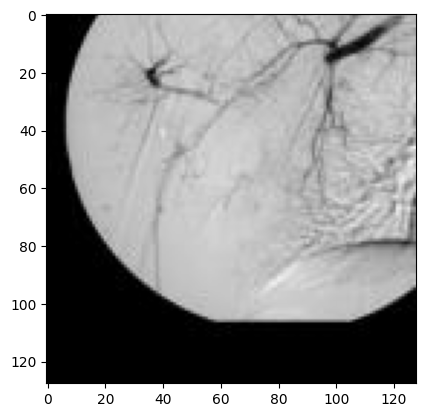

Prediction:	This is a photo of a angiography, confidence 33.644%
Actual class:	angiography
Right Prediction
#########################################################
                  precision    recall  f1-score   support

     angiography       1.00      1.00      1.00         1
echocardiography       1.00      1.00      1.00         1
      ultrasound       1.00      1.00      1.00         1
      tomography       1.00      1.00      1.00         1
            xray       1.00      1.00      1.00         1

        accuracy                           1.00         5
       macro avg       1.00      1.00      1.00         5
    weighted avg       1.00      1.00      1.00         5



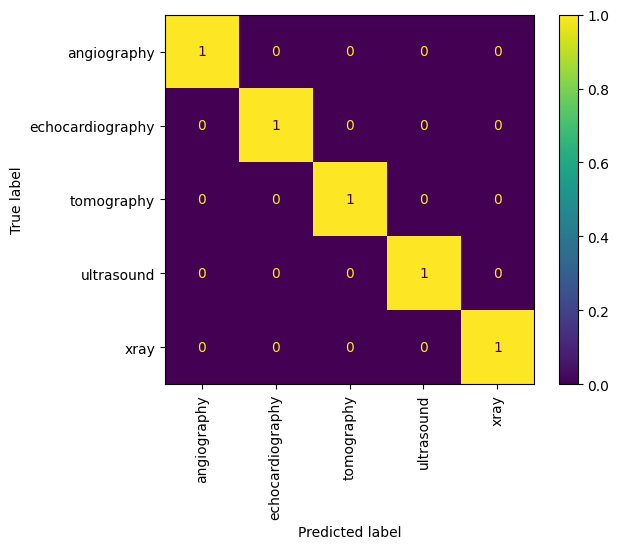

In [19]:
evaluate_zeroshot(reference_p, zeroshot_results_p, classification_labels, images=images, vis=True)